In [32]:
%env CUDA_VISIBLE_DEVICES=-1
from typing import Callable, Dict, List, Optional

import math
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import torch
from chirho.counterfactual.handlers.counterfactual import \
    MultiWorldCounterfactual
from chirho.explainable.handlers import ExtractSupports, SearchForExplanation
from chirho.indexed.ops import IndexSet, gather
from chirho.observational.handlers import condition

pyro.settings.set(module_local_params=True)

env: CUDA_VISIBLE_DEVICES=-1


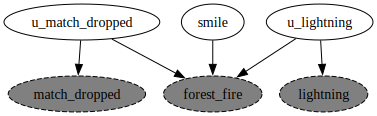

In [33]:
def forest_fire_model():
    u_match_dropped = pyro.sample("u_match_dropped", dist.Bernoulli(0.7))
    match_dropped = pyro.deterministic(
        "match_dropped", u_match_dropped, event_dim=0
    )  # notice uneven probs here

    u_lightning = pyro.sample("u_lightning", dist.Bernoulli(0.4))
    lightning = pyro.deterministic("lightning", u_lightning, event_dim=0)

    # this is a causally irrelevant site
    smile = pyro.sample("smile", dist.Bernoulli(0.5))

    forest_fire = pyro.deterministic(
        "forest_fire", torch.max(match_dropped, lightning) + (0 * smile), event_dim=0
    )

    return {
        "match_dropped": match_dropped,
        "lightning": lightning,
        "forest_fire": forest_fire
    }

with ExtractSupports() as extract_supports:
    forest_fire_model()
    forest_fire_supports = {k: constraints.boolean for k in extract_supports.supports}

pyro.render_model(forest_fire_model)


In [76]:
query = SearchForExplanation(
    supports=forest_fire_supports,
    antecedents={"match_dropped": torch.tensor(1.0)},
    consequents={"lightning": torch.tensor(1.0)},
    # consequents={"lightning": torch.tensor(1.0)},
    witnesses={}, # potential context elements, we leave them empty for now
    alternatives={"match_dropped": torch.tensor(0.0)},
    antecedent_bias=-0.5,
    consequent_scale=0,
)(forest_fire_model)

In [80]:
with MultiWorldCounterfactual() as mwc:  
        with SearchForExplanation(
            supports=forest_fire_supports,
            antecedents={"match_dropped": torch.tensor(1.0)},
            consequents={"forest_fire": torch.tensor(1.0)},
            # consequents={"lightning": torch.tensor(1.0)},
            witnesses={}, # potential context elements, we leave them empty for now
            alternatives={"match_dropped": torch.tensor(0.0)},
            antecedent_bias=-0.5,
            consequent_scale=0,
        ):
            with pyro.plate("sample", size=15):
                with pyro.poutine.trace() as trace:
                    forest_fire_model()

{'match_dropped': tensor(1.)}


In [84]:
trace.trace.nodes.keys()

for name, node in trace.trace.nodes.items():
    print(name)
    print(node["value"])
    print(node["log_probs"])
    # print(node)
    # print(node["log_prob"])

trace.trace.nodes["__cause____consequent_forest_fire"]["fn"].log_factor

u_match_dropped
tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.])


KeyError: 'log_probs'